## SI epidemic simulations: spread of infection in communities over time

In [1]:
import networkx as nx
import EoN

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator
from matplotlib import gridspec

from tqdm.notebook import tqdm

In [2]:
TAU = 0.1
TMAX = 10
N_TRIALS = 1
N_RUNS = 1

In [3]:
# Import Reddit Hyperlink network
edges = np.loadtxt('data/edges.csv', delimiter=',', dtype=int, skiprows=1)
G = nx.Graph()
G.add_edges_from(edges)

# Import communities
node_community = pd.read_csv('data/communities.csv', index_col=0)

# Extract 5 largest communities
print(node_community.value_counts().head())

top_community_ids = node_community.value_counts().head().index.get_level_values(0).to_list()
top_community_nodes = {community_rank: node_community[node_community == community_id].dropna().index.to_list()
                       for community_rank, community_id in enumerate(top_community_ids)}

modularity_class
11                  5757
8                   5358
7                   4408
16                  2951
10                  2334
dtype: int64


In [4]:
top_community_nodes.keys()

dict_keys([0, 1, 2, 3, 4])

In [5]:
def simulate_si(G: nx.Graph, tau: float, tmax: float, top_community_nodes: dict[int, list[int]], initial_community: int, n_runs: int) -> np.ndarray:
    """Docstring"""

    t_grid = np.linspace(0, tmax, 100)
    infected = np.zeros((n_runs, len(top_community_nodes), len(t_grid)))

    for run in range(n_runs):
        initial_infected = np.random.choice(top_community_nodes[initial_community])
        print(f"Initial infected: {initial_infected} (community {initial_community})")
        
        sim = EoN.fast_SIR(G, tau, gamma=0, initial_infecteds=initial_infected, tmax=tmax, return_full_data=True)
        
        for community, nodes in top_community_nodes.items():
            I = [sum([1 for status in sim.get_statuses(nodes, t).values() if status == 'I']) for t in t_grid]
            infected[run, community] = I
        
    mean_infected = np.mean(infected, axis=0)

    return mean_infected

In [6]:
# Dictionary to store final results
community_infected = {}

for inital_community in top_community_nodes:

    # Array to store results of each trial
    mean_trial_infected = np.zeros((N_TRIALS, len(top_community_nodes), len(np.linspace(0, TMAX, 100))))

    print(f"Community {inital_community + 1}")

    for trial in tqdm(range(N_TRIALS)):

        # Run simulations
        mean_run_infected = simulate_si(G, tau=TAU, tmax=TMAX, n_runs=N_RUNS,
                                        top_community_nodes=top_community_nodes,
                                        initial_community=inital_community)

        # Store results
        mean_trial_infected[trial] = mean_run_infected

    # Average over trials
    mean_trial_infected = np.mean(mean_trial_infected, axis=0)

    # Store results
    community_infected[inital_community] = mean_trial_infected

Community 1


  0%|          | 0/1 [00:00<?, ?it/s]

Initial infected: 3684 (community 0)
Community 2


  0%|          | 0/1 [00:00<?, ?it/s]

Initial infected: 21584 (community 1)
Community 3


  0%|          | 0/1 [00:00<?, ?it/s]

Initial infected: 30783 (community 2)
Community 4


  0%|          | 0/1 [00:00<?, ?it/s]

Initial infected: 26935 (community 3)
Community 5


  0%|          | 0/1 [00:00<?, ?it/s]

Initial infected: 29740 (community 4)


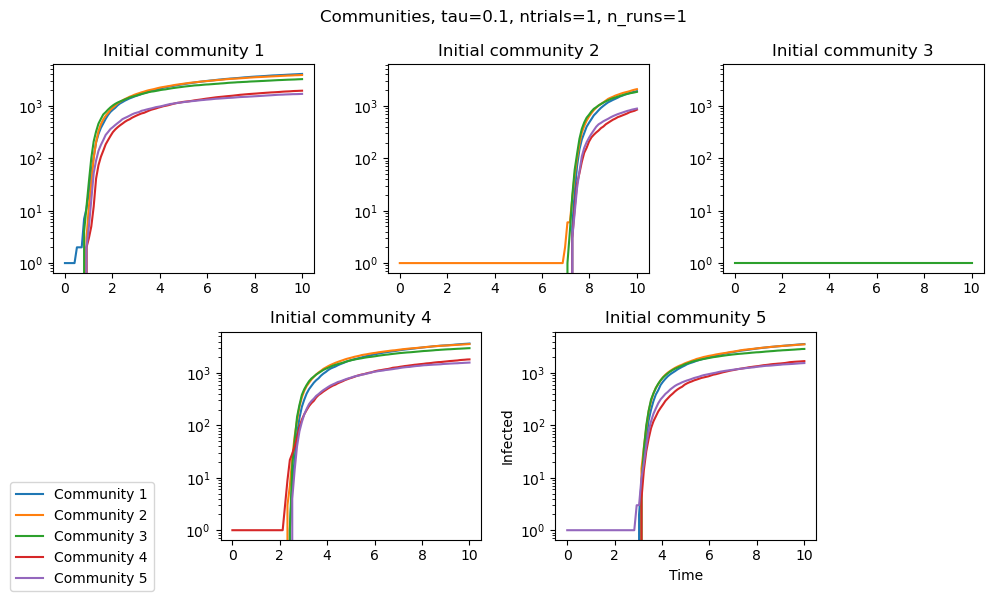

In [9]:
# Plot the results
fig = plt.figure(figsize=(10, 6))
fig.suptitle(f"Communities, tau={TAU}, ntrials={N_TRIALS}, n_runs={N_RUNS}")
gs = fig.add_gridspec(2, 6)

ax1 = fig.add_subplot(gs[0, :2])
ax2 = fig.add_subplot(gs[0, 2:4], sharey=ax1)
ax3 = fig.add_subplot(gs[0, 4:], sharey=ax1)
ax4 = fig.add_subplot(gs[1, 1:3], sharey=ax1)
ax5 = fig.add_subplot(gs[1, 3:5], sharey=ax1)

axs = [ax1, ax2, ax3, ax4, ax5]

for ax, initial_community in zip(axs, community_infected):
    for inital_community in top_community_nodes:
        ax.plot(np.linspace(0, TMAX, 100), community_infected[initial_community][inital_community], label=f"Community {inital_community + 1}")
    ax.set_title(f"Initial community {initial_community + 1}")
    ax.set_xlabel('Time')
    ax.set_ylabel('Infected')

ax.set_yscale('log')

# Common legend
legend = fig.legend(*ax.get_legend_handles_labels(), loc='lower left', bbox_to_anchor=(0, 0))

plt.tight_layout()
plt.show()

## Random

In [8]:
# Create random graph with same number of nodes and edges
G_random = nx.gnm_random_graph(G.number_of_nodes(), G.number_of_edges())

In [10]:
# Dictionary to store final results
community_infected_random = {}

for inital_community in top_community_nodes:
    
    # Array to store results of each trial
    mean_trial_infected = np.zeros((N_TRIALS, len(top_community_nodes), len(np.linspace(0, TMAX, 100))))

    print(f"Community {inital_community + 1}")

    for trial in tqdm(range(N_TRIALS)):

        # Run simulations
        mean_run_infected = simulate_si(G_random, tau=TAU, tmax=TMAX, n_runs=N_RUNS,
                                        top_community_nodes=top_community_nodes,
                                        initial_community=inital_community)

        # Store results
        mean_trial_infected[trial] = mean_run_infected

    # Average over trials
    mean_trial_infected = np.mean(mean_trial_infected, axis=0)

    # Store results
    community_infected_random[inital_community] = mean_trial_infected

Community 1


  0%|          | 0/1 [00:00<?, ?it/s]

Initial infected: 12343 (community 0)
Community 2


  0%|          | 0/1 [00:00<?, ?it/s]

Initial infected: 10115 (community 1)
Community 3


  0%|          | 0/1 [00:00<?, ?it/s]

Initial infected: 22205 (community 2)
Community 4


  0%|          | 0/1 [00:00<?, ?it/s]

Initial infected: 31277 (community 3)
Community 5


  0%|          | 0/1 [00:00<?, ?it/s]

Initial infected: 29210 (community 4)


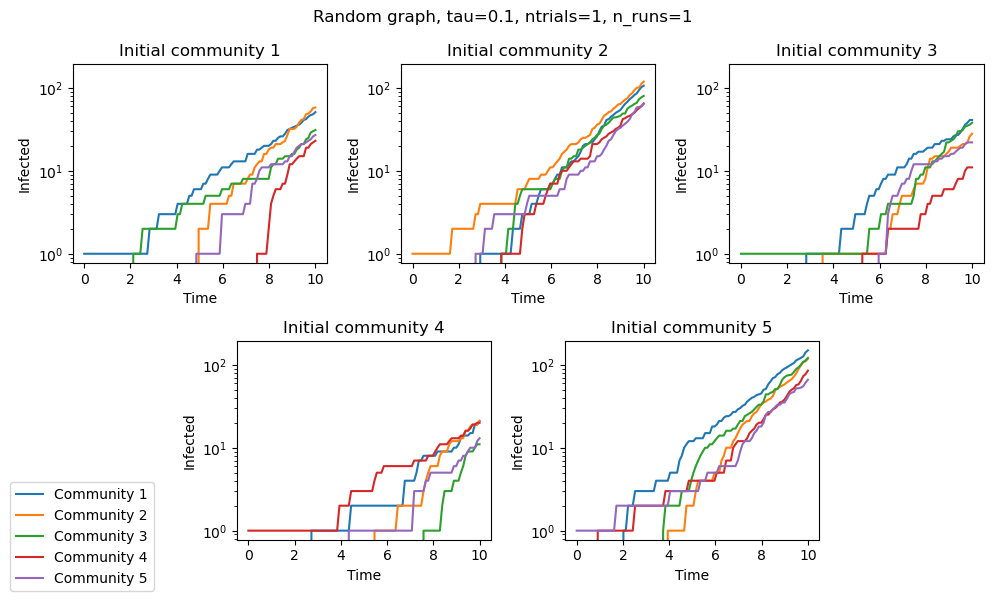

In [13]:
# Plot the results
fig = plt.figure(figsize=(10, 6))
fig.suptitle(f"Random graph, tau={TAU}, ntrials={N_TRIALS}, n_runs={N_RUNS}")

gs = fig.add_gridspec(2, 6)

ax1 = fig.add_subplot(gs[0, :2])
ax2 = fig.add_subplot(gs[0, 2:4], sharey=ax1)
ax3 = fig.add_subplot(gs[0, 4:], sharey=ax1)
ax4 = fig.add_subplot(gs[1, 1:3], sharey=ax1)
ax5 = fig.add_subplot(gs[1, 3:5], sharey=ax1)

axs = [ax1, ax2, ax3, ax4, ax5]

for ax, initial_community in zip(axs, community_infected_random):
    for inital_community in top_community_nodes:
        ax.plot(np.linspace(0, TMAX, 100), community_infected_random[initial_community][inital_community], label=f"Community {inital_community + 1}")
    ax.set_title(f"Initial community {initial_community + 1}")
    ax.set_xlabel('Time')
    ax.set_ylabel('Infected')

ax.set_yscale('log')

# Common legend
legend = fig.legend(*ax.get_legend_handles_labels(), loc='lower left', bbox_to_anchor=(0, 0))

plt.tight_layout()
plt.show()